## Notebook Documentation

This notebook performs a machine learning workflow to predict `Stitch Length` and `Yarn Count` based on various fabric properties. The main steps involved are:

### 1. Data Loading and Initial Cleaning
- Multiple Excel files (`mldata.xlsx`, `fkl1.xlsx`, `fkl2.xlsx`) were loaded into pandas DataFrames.
- Column headers were standardized and unnecessary columns (`Dia`, `F. Dia`, `FINISHED DIA`, `Construction`) were dropped.
- Columns like `Color Range` and `Stich` were renamed to `Color` and `Stitch Length` respectively for consistency.
- `M/C Dia & Gauge` column was split into `M/C Dia` and `Gauge`, and converted to numeric types.

### 2. Data Concatenation and Standardization
- The three cleaned DataFrames (`df`, `df1`, `df2`) were concatenated into a single DataFrame (`df3`).
- `Color` column entries were standardized (e.g., 'Color' and 'Colour' variations removed, 'avg' to 'Average', 'white' to 'White', 'black' to 'Black').
- `Fabrication` column was extensively cleaned and standardized, including converting to uppercase, normalizing special characters, removing spaces, and mapping to a consistent set of terms.

### 3. Feature Engineering: Composition
- The `Composition` column was parsed to extract percentages of different fiber types (e.g., Cotton, Polyester, Elastane, etc.).
- New columns were created for each fiber type's percentage (e.g., `Cotton_pct`, `Polyester_pct`).
- A check was performed to ensure that the sum of fiber percentages was approximately 100%, and rows with problematic sums were inspected (none found in this run).
- `Other_pct` and `composition_sum` columns were dropped after validation.

### 4. Feature Engineering: Stitch Length and Yarn Count
- A function `is_valid_stitch_length` was applied to filter out ambiguous `Stitch Length` entries, removing a small number of rows.
- `Stitch Length` was split into `SL_ground` and `SL_elastane` numeric columns using the `split_stitch_length` function.
- `Yarn Count` was split into `YC_ground_Ne`, `YC_ground_Denier`, `YC_ground_Filament`, and `YC_elastane_Denier` numeric columns using the `split_yarn_count` function.
- Ambiguous yarn-count rows were checked (none found in this run).

### 5. Model Training and Evaluation
- The processed DataFrame `df3` was split into features (`X`) and target variables (`y`). The target variables are `SL_ground`, `SL_elastane`, `YC_ground_Ne`, `YC_ground_Denier`, `YC_ground_Filament`, and `YC_elastane_Denier`.
- Rows with all-zero target values (bad labels) were removed.
- Categorical features (`Fabrication`) were converted to appropriate types.
- The data was split into training and testing sets (`X_train`, `X_test`, `y_train`, `y_test`).
- Three different machine learning models were trained for each target variable:
    - **LightGBM Regressor**
    - **CatBoost Regressor**
    - **XGBoost Regressor**
- Model performance was evaluated using Mean Absolute Error (MAE) and R² Score on the test set.
- Results were aggregated and visualized to compare the performance of the models across all target variables. XGBoost was identified as the best performing model based on average MAE and R2 score.

### 6. Prediction Formatting and Output
- Utility functions (`snap_to_valid`, `format_yarn_count`, `format_stitch_length`) were defined to format the numeric predictions back into user-friendly `Stitch Length` and `Yarn Count` strings.
- Physical constraints were applied to the predictions (e.g., no elastane implies zero elastane SL or yarn).
- The `X_test` features were reconstructed, including re-creating the `Color` column from one-hot encodings and `Composition` from fiber percentages.
- A final comparison DataFrame (`final_comparison_df`) was created, showing the input features alongside actual and predicted `Stitch Length` and `Yarn Count` values.
- The final comparison DataFrame was displayed and exported to an Excel file (`actual_vs_predicted_results.xlsx`).

In [ ]:
import pandas as pd
from datetime import datetime

# Load Excel WITHOUT forcing dtype
df = pd.read_excel("mldata.xlsx")

def fix_yarn_count(value):
    # If pandas converted it to datetime
    if isinstance(value, (pd.Timestamp, datetime)):
        return f"{value.day}/1"

    # If it is still string like '16-Jan'
    if isinstance(value, str) and value.endswith("-Jan"):
        return value.replace("-Jan", "/1")

    return value

# Apply to entire dataframe
df = df.applymap(fix_yarn_count)

# Save cleaned data
df.to_csv("mldata_cleaned.csv", index=False)

print("Yarn count correction completed.")


/tmp/ipython-input-3555708570.py:19: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df = df.applymap(fix_yarn_count)


Yarn count correction completed.


In [ ]:
df[4420:4470]

,M/C Dia & Gauge,Yarn Count,Construction,Composition,Color Range,Stich,Dia,GSM
4420,36 X 24,30/1,S/J,100%Cotton,Black Color,3.00,76,140
4421,36 X 24,30/1,S/J,100%Cotton,Average Color,3.00,76,140
4422,30 X 20,30/1,S/J,100%Cotton,Dark Color,3.45/3.55,64,240
4423,30 X 20,30/1,S/J,100%Cotton,Dark Color,3.45/3.55,64,240
4424,30 X 20,30/1,S/J,100%Cotton,Dark Color,3.45/3.55,64,240
4425,30 X 20,30/1,S/J,100%Cotton,Dark Color,3.45/3.55,64,240
4426,30 X 20,30/1,S/J,100%Cotton,Dark Color,3.45/3.55,64,240
4427,30 X 20,30/1,S/J,100%Cotton,Dark Color,3.45/3.55,64,240
4428,30 X 20,30/1,S/J,100%Cotton,Dark Color,3.45/3.55,64,240
4429,30 X 20,30/1,S/J,100%Cotton,Dark Color,3.45/3.55,64,240


In [ ]:
df = df.drop(columns=['Dia'])

In [ ]:
df

,M/C Dia & Gauge,Yarn Count,Construction,Composition,Color Range,Stich,GSM
0,30 X 20,16/1,S/J,100%Cotton,Wash,3.45,230
1,26 X 24,20/1,Pique,100%Cotton,White Color,2.85/2.75,280
2,34 X 18,20/1,1X1 Rib,100%Cotton,Medium Color,2.90,290
3,26 X 24,20/1,Pique,100%Cotton,Medium Color,2.90/2.80,280
4,32 X 24,20/1,S/J,100%Cotton,Medium Color,3.00,200
...,...,...,...,...,...,...,...
10087,30 X 28,"75D/72F,40/D",LS/J,"83% Polyester,17% Elastane",Black Color,3.25/1.20,135
10088,30 X 28,"75D/72F,40/D",LS/J,"83% Polyester,17% Elastane",Black Color,3.25/1.20,135
10089,30 X 28,"75D/72F,40/D",LS/J,"83% Polyester,17% Elastane",Black Color,3.25/1.20,135
10090,30 X 28,"75D/72F,40/D",LS/J,"83% Polyester,17% Elastane",Black Color,3.25/1.20,135


In [ ]:
df['Fabrication'] = df['Construction']


In [ ]:
df.drop(columns=['Construction'], inplace=True)

In [ ]:
df

,M/C Dia & Gauge,Yarn Count,Composition,Color Range,Stich,GSM,Fabrication
0,30 X 20,16/1,100%Cotton,Wash,3.45,230,S/J
1,26 X 24,20/1,100%Cotton,White Color,2.85/2.75,280,Pique
2,34 X 18,20/1,100%Cotton,Medium Color,2.90,290,1X1 Rib
3,26 X 24,20/1,100%Cotton,Medium Color,2.90/2.80,280,Pique
4,32 X 24,20/1,100%Cotton,Medium Color,3.00,200,S/J
...,...,...,...,...,...,...,...
10087,30 X 28,"75D/72F,40/D","83% Polyester,17% Elastane",Black Color,3.25/1.20,135,LS/J
10088,30 X 28,"75D/72F,40/D","83% Polyester,17% Elastane",Black Color,3.25/1.20,135,LS/J
10089,30 X 28,"75D/72F,40/D","83% Polyester,17% Elastane",Black Color,3.25/1.20,135,LS/J
10090,30 X 28,"75D/72F,40/D","83% Polyester,17% Elastane",Black Color,3.25/1.20,135,LS/J


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10092 entries, 0 to 10091
Data columns (total 7 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   M/C Dia & Gauge  10092 non-null  object
 1   Yarn Count       10092 non-null  object
 2   Composition      10092 non-null  object
 3   Color Range      10092 non-null  object
 4   Stich            10092 non-null  object
 5   GSM              10092 non-null  object
 6   Fabrication      10092 non-null  object
dtypes: object(7)
memory usage: 552.0+ KB


In [ ]:
new_order = ['Fabrication', 'Composition', 'M/C Dia & Gauge', 'Color Range', 'GSM', 'Stich', 'Yarn Count']
df = df[new_order]
df

,Fabrication,Composition,M/C Dia & Gauge,Color Range,GSM,Stich,Yarn Count
0,S/J,100%Cotton,30 X 20,Wash,230,3.45,16/1
1,Pique,100%Cotton,26 X 24,White Color,280,2.85/2.75,20/1
2,1X1 Rib,100%Cotton,34 X 18,Medium Color,290,2.90,20/1
3,Pique,100%Cotton,26 X 24,Medium Color,280,2.90/2.80,20/1
4,S/J,100%Cotton,32 X 24,Medium Color,200,3.00,20/1
...,...,...,...,...,...,...,...
10087,LS/J,"83% Polyester,17% Elastane",30 X 28,Black Color,135,3.25/1.20,"75D/72F,40/D"
10088,LS/J,"83% Polyester,17% Elastane",30 X 28,Black Color,135,3.25/1.20,"75D/72F,40/D"
10089,LS/J,"83% Polyester,17% Elastane",30 X 28,Black Color,135,3.25/1.20,"75D/72F,40/D"
10090,LS/J,"83% Polyester,17% Elastane",30 X 28,Black Color,135,3.25/1.20,"75D/72F,40/D"


In [ ]:
# Split 'M/C Dia & Gauge' into two new columns
df[['M/C Dia', 'Gauge']] = df['M/C Dia & Gauge'].str.split(' X ', expand=True)

# Convert new columns to numeric, handling potential errors
df['M/C Dia'] = pd.to_numeric(df['M/C Dia'], errors='coerce')
df['Gauge'] = pd.to_numeric(df['Gauge'], errors='coerce')

# Drop the original 'M/C Dia & Gauge' column
df.drop(columns=['M/C Dia & Gauge'], inplace=True)

# Reorder columns to place new columns appropriately
# Assuming the desired order is Fabrication, Composition, M/C Dia, Gauge, Color Range, GSM, Stich, Yarn Count
current_columns = df.columns.tolist()

# Get the index of the old 'M/C Dia & Gauge' in the original ordered list if it were still there
# Based on cell KPDEDF-nVjQ8: new_order = ['Fabrication', 'Composition', 'M/C Dia & Gauge', 'Color Range', 'GSM', 'Stich', 'Yarn Count']
# So 'M/C Dia & Gauge' was at index 2

# Construct the new order
new_ordered_columns = [
    'Fabrication',
    'Composition',
    'M/C Dia',
    'Gauge',
    'Color Range',
    'GSM',
    'Stich',
    'Yarn Count'
]
df = df[new_ordered_columns]

print("Columns 'M/C Dia' and 'Gauge' created successfully.")
df.head()

Columns 'M/C Dia' and 'Gauge' created successfully.


/tmp/ipython-input-3781007527.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[['M/C Dia', 'Gauge']] = df['M/C Dia & Gauge'].str.split(' X ', expand=True)
/tmp/ipython-input-3781007527.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[['M/C Dia', 'Gauge']] = df['M/C Dia & Gauge'].str.split(' X ', expand=True)
/tmp/ipython-input-3781007527.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See t

,Fabrication,Composition,M/C Dia,Gauge,Color Range,GSM,Stich,Yarn Count
0,S/J,100%Cotton,30,20,Wash,230,3.45,16/1
1,Pique,100%Cotton,26,24,White Color,280,2.85/2.75,20/1
2,1X1 Rib,100%Cotton,34,18,Medium Color,290,2.90,20/1
3,Pique,100%Cotton,26,24,Medium Color,280,2.90/2.80,20/1
4,S/J,100%Cotton,32,24,Medium Color,200,3.00,20/1


In [ ]:
df.rename(columns={'Color Range': 'Color'}, inplace=True)


In [ ]:
df.rename(columns={'Stich': 'Stitch Length'}, inplace=True)
df

,Fabrication,Composition,M/C Dia,Gauge,Color,GSM,Stitch Length,Yarn Count
0,S/J,100%Cotton,30,20,Wash,230,3.45,16/1
1,Pique,100%Cotton,26,24,White Color,280,2.85/2.75,20/1
2,1X1 Rib,100%Cotton,34,18,Medium Color,290,2.90,20/1
3,Pique,100%Cotton,26,24,Medium Color,280,2.90/2.80,20/1
4,S/J,100%Cotton,32,24,Medium Color,200,3.00,20/1
...,...,...,...,...,...,...,...,...
10087,LS/J,"83% Polyester,17% Elastane",30,28,Black Color,135,3.25/1.20,"75D/72F,40/D"
10088,LS/J,"83% Polyester,17% Elastane",30,28,Black Color,135,3.25/1.20,"75D/72F,40/D"
10089,LS/J,"83% Polyester,17% Elastane",30,28,Black Color,135,3.25/1.20,"75D/72F,40/D"
10090,LS/J,"83% Polyester,17% Elastane",30,28,Black Color,135,3.25/1.20,"75D/72F,40/D"


In [ ]:
import pandas as pd
from datetime import datetime

# Load Excel WITHOUT forcing dtype, using header from the second row (index 1)
# This results in the first row of the dataframe (index 0) containing the actual header values
df1 = pd.read_excel("/content/fkl1.xlsx", header=1)

# Set the column names from the first row of the dataframe
df1.columns = df1.iloc[0]

# Drop the first row as it's now the header
df1 = df1[1:]

# Reset the index
df1 = df1.reset_index(drop=True)

def fix_yarn_count(value):
    # If pandas converted it to datetime
    if isinstance(value, (pd.Timestamp, datetime)):
        return f"{value.day}/1"

    # If it is still string like '16-Jan'
    if isinstance(value, str) and value.endswith("-Jan"):
        return value.replace("-Jan", "/1")

    return value

# Apply to entire dataframe (using .map() to address FutureWarning)
df1 = df1.map(fix_yarn_count)
df1.to_csv("fkl1.csv", index=False, encoding='utf-8-sig')

print("Conversion completed!")
df1

Conversion completed!


,Fabrication,GSM,Composition,Count,MC Dia,Gauge,F. Dia,SL,Colour
0,4*2L- rib,190,"95%Cotton,5%Elastane","34/1,20/D",40,18,6.0,2.72/1.35,avg
1,Interlock,235,100%Cotton,40/1,38,24,72.0,2.7,Dark Color
2,Interlock,235,100%Cotton,34/1,36,24,72.0,3,white
3,Interlock,235,100%Cotton,34/1,36,24,72.0,3,white
4,Pique,200,100%Cotton,26/1,30,24,72.0,2.64,Dark Color
5,S/J,160,"60%Cotton,40%Polyester",30/1,34,24,NaN,2.7,Dark Color
6,S/J,145,100%Cotton,30/1,40,24,76.0,2.8,Light color
7,S/J,180,100%Cotton,24/1,30,24,64.0,2.9,Light color
8,S/J,160,100%Cotton,30/1,32,24,68.0,2.96,Black
9,S/J,180,"75%Cotton, 25%Recycle Cotton",34/1,40,24,NaN,3,avg


In [ ]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20 entries, 0 to 19
Data columns (total 9 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Fabrication   20 non-null     object 
 1   GSM           20 non-null     int64  
 2   Composition   20 non-null     object 
 3   Count         20 non-null     object 
 4   MC Dia        20 non-null     int64  
 5   Gauge         20 non-null     int64  
 6   F. Dia        15 non-null     float64
 7   SL            20 non-null     object 
 8   Colour        20 non-null     object 
dtypes: float64(1), int64(3), object(5)
memory usage: 1.5+ KB


In [ ]:
df1.rename(columns={'Colour':'Color', 'Count':'Yarn Count', 'SL':'Stitch Length', 'MC Dia':'M/C Dia'}, inplace=True)
df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20 entries, 0 to 19
Data columns (total 9 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Fabrication    20 non-null     object 
 1   GSM            20 non-null     int64  
 2   Composition    20 non-null     object 
 3   Yarn Count     20 non-null     object 
 4   M/C Dia        20 non-null     int64  
 5   Gauge          20 non-null     int64  
 6   F. Dia         15 non-null     float64
 7   Stitch Length  20 non-null     object 
 8   Colour         20 non-null     object 
dtypes: float64(1), int64(3), object(5)
memory usage: 1.5+ KB


In [ ]:
df1.drop(columns=['F. Dia'], inplace=True)

In [ ]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20 entries, 0 to 19
Data columns (total 8 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   Fabrication    20 non-null     object
 1   GSM            20 non-null     int64 
 2   Composition    20 non-null     object
 3   Yarn Count     20 non-null     object
 4   M/C Dia        20 non-null     int64 
 5   Gauge          20 non-null     int64 
 6   Stitch Length  20 non-null     object
 7   Colour         20 non-null     object
dtypes: int64(3), object(5)
memory usage: 1.4+ KB


In [ ]:
df1.columns = df1.columns.str.strip()

# Rename the 'Colour' column to 'Color' if it exists
if 'Colour' in df1.columns:
    df1.rename(columns={'Colour': 'Color'}, inplace=True)

new_ordered_columns = [
    'Fabrication',
    'Composition',
    'M/C Dia',
    'Gauge',
    'Color',
    'GSM',
    'Stitch Length',
    'Yarn Count'
]
df1 = df1[new_ordered_columns]
df1

,Fabrication,Composition,M/C Dia,Gauge,Color,GSM,Stitch Length,Yarn Count
0,4*2L- rib,"95%Cotton,5%Elastane",40,18,avg,190,2.72/1.35,"34/1,20/D"
1,Interlock,100%Cotton,38,24,Dark Color,235,2.7,40/1
2,Interlock,100%Cotton,36,24,white,235,3,34/1
3,Interlock,100%Cotton,36,24,white,235,3,34/1
4,Pique,100%Cotton,30,24,Dark Color,200,2.64,26/1
5,S/J,"60%Cotton,40%Polyester",34,24,Dark Color,160,2.7,30/1
6,S/J,100%Cotton,40,24,Light color,145,2.8,30/1
7,S/J,100%Cotton,30,24,Light color,180,2.9,24/1
8,S/J,100%Cotton,32,24,Black,160,2.96,30/1
9,S/J,"75%Cotton, 25%Recycle Cotton",40,24,avg,180,3,34/1


In [ ]:
import pandas as pd
from datetime import datetime

# Load Excel WITHOUT forcing dtype, using header from the second row (index 1)
# This results in the first row of the dataframe (index 0) containing the actual header values
df2 = pd.read_excel("/content/fkl2.xlsx", header=1)

# Set the column names from the first row of the dataframe
df2.columns = df2.iloc[0]

# Drop the first row as it's now the header
df2 = df2[1:]

# Reset the index
df2 = df2.reset_index(drop=True)

def fix_yarn_count(value):
    # If pandas converted it to datetime
    if isinstance(value, (pd.Timestamp, datetime)):
        return f"{value.day}/1"

    # If it is still string like '16-Jan'
    if isinstance(value, str) and value.endswith("-Jan"):
        return value.replace("-Jan", "/1")

    return value

# Apply to entire dataframe (using .map() to address FutureWarning)
df2 = df2.map(fix_yarn_count)
df2.to_csv("fkl2.csv", index=False, encoding='utf-8-sig')

print("Conversion completed!")
df2

Conversion completed!


,FABRICATION,GSM,COMPOSITION,COUNT,SL,M/C DIA,FINISHED DIA,COLOR RANGE,GAUGE
0,4×2L- Rib,190,"95% Cotton ,5%Elastane","34/1,20/D",2.72/1.35,40,61,AVG,18
1,4×2L- Rib,190,"95% Cotton ,5%Elastane","34/1,20/D",2.72/1.35,40,61,AVG,18
2,LS/J,160,"95%%Cotton,5%Elastane","40/1,20/D",2.94/1.05,40,76,AVG,24
3,1×1L- Rib,215,"95% Cotton,5%Elastane","34/1,20/D",3.15/1.15,38,72,AVG,24
4,S/J,155,"95%Cotton,5%Elastane","50/1,30/D",2.74/ 1.00,38,68,AVG,24
5,S/J,200,100% cotton,20/1,3.05,36,68,Light Color,24
6,S/J,145,100% cotton,30/1,3,38,80,Black Color,24
7,2×2L- Rib,380,"60%Cotton,35%Polyester,5%Elastane","24/1,70/D",2.86/1.1,44,56,Black Color,18
8,2×2L- Rib,380,"60%Cotton,35%Polyester,5%Elastane","24/1,70/D",2.86/1.2,42,52,Black Color,18
9,LS/J,160,"80%Cotton,15%Recycle Cotton,5%Elastane","30/1,20/D",3.2/1.2,36,82,Black Color,24


In [ ]:
df2.columns = df2.columns.str.strip()
df2.drop(columns=['FINISHED DIA'], inplace=True)

In [ ]:
df2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26 entries, 0 to 25
Data columns (total 8 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   FABRICATION  26 non-null     object
 1   GSM          26 non-null     int64 
 2   COMPOSITION  26 non-null     object
 3   COUNT        26 non-null     object
 4   SL           26 non-null     object
 5   M/C DIA      26 non-null     int64 
 6   COLOR RANGE  26 non-null     object
 7   GAUGE        26 non-null     int64 
dtypes: int64(3), object(5)
memory usage: 1.8+ KB


In [ ]:
df2.rename(columns={'FABRICATION':'Fabrication','COMPOSITION':'Composition','GAUGE':'Gauge','COLOR RANGE':'Color', 'COUNT':'Yarn Count', 'SL':'Stitch Length', 'M/C DIA':'M/C Dia'}, inplace=True)
df2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26 entries, 0 to 25
Data columns (total 8 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   Fabrication    26 non-null     object
 1   GSM            26 non-null     int64 
 2   Composition    26 non-null     object
 3   Yarn Count     26 non-null     object
 4   Stitch Length  26 non-null     object
 5   M/C Dia        26 non-null     int64 
 6   Color          26 non-null     object
 7   Gauge          26 non-null     int64 
dtypes: int64(3), object(5)
memory usage: 1.8+ KB


In [ ]:
new_ordered_columns = [
    'Fabrication',
    'Composition',
    'M/C Dia',
    'Gauge',
    'Color',
    'GSM',
    'Stitch Length',
    'Yarn Count'
]
df2 = df2[new_ordered_columns]
df2

,Fabrication,Composition,M/C Dia,Gauge,Color,GSM,Stitch Length,Yarn Count
0,4×2L- Rib,"95% Cotton ,5%Elastane",40,18,AVG,190,2.72/1.35,"34/1,20/D"
1,4×2L- Rib,"95% Cotton ,5%Elastane",40,18,AVG,190,2.72/1.35,"34/1,20/D"
2,LS/J,"95%%Cotton,5%Elastane",40,24,AVG,160,2.94/1.05,"40/1,20/D"
3,1×1L- Rib,"95% Cotton,5%Elastane",38,24,AVG,215,3.15/1.15,"34/1,20/D"
4,S/J,"95%Cotton,5%Elastane",38,24,AVG,155,2.74/ 1.00,"50/1,30/D"
5,S/J,100% cotton,36,24,Light Color,200,3.05,20/1
6,S/J,100% cotton,38,24,Black Color,145,3,30/1
7,2×2L- Rib,"60%Cotton,35%Polyester,5%Elastane",44,18,Black Color,380,2.86/1.1,"24/1,70/D"
8,2×2L- Rib,"60%Cotton,35%Polyester,5%Elastane",42,18,Black Color,380,2.86/1.2,"24/1,70/D"
9,LS/J,"80%Cotton,15%Recycle Cotton,5%Elastane",36,24,Black Color,160,3.2/1.2,"30/1,20/D"


In [ ]:
print('df columns:', df.columns.tolist())
print('df1 columns:', df1.columns.tolist())
print('df2 columns:', df2.columns.tolist())

df columns: ['Fabrication', 'Composition', 'M/C Dia', 'Gauge', 'Color', 'GSM', 'Stitch Length', 'Yarn Count']
df1 columns: ['Fabrication', 'Composition', 'M/C Dia', 'Gauge', 'Color', 'GSM', 'Stitch Length', 'Yarn Count']
df2 columns: ['Fabrication', 'Composition', 'M/C Dia', 'Gauge', 'Color', 'GSM', 'Stitch Length', 'Yarn Count']


In [ ]:
df3 = pd.concat([df, df1, df2], ignore_index=True)
print("DataFrames df1 and df2 have been concatenated into df3.")
df3

DataFrames df1 and df2 have been concatenated into df3.


,Fabrication,Composition,M/C Dia,Gauge,Color,GSM,Stitch Length,Yarn Count
0,S/J,100%Cotton,30,20,Wash,230,3.45,16/1
1,Pique,100%Cotton,26,24,White Color,280,2.85/2.75,20/1
2,1X1 Rib,100%Cotton,34,18,Medium Color,290,2.90,20/1
3,Pique,100%Cotton,26,24,Medium Color,280,2.90/2.80,20/1
4,S/J,100%Cotton,32,24,Medium Color,200,3.00,20/1
...,...,...,...,...,...,...,...,...
10133,LS/J,"80%Cotton,15%Recycle Cotton,5%Elastane",40,24,White Color,180,3.14/1.2,"30/1,20/D"
10134,LS/J,"80%Cotton,15%Recycle Cotton,5%Elastane",40,24,White Color,180,3.14/1.2,"30/1,20/D"
10135,LS/J,"80%Cotton,15%Recycle Cotton,5%Elastane",40,24,White Color,180,3.14/1.2,"30/1,20/D"
10136,LS/J,"80%Cotton,15%Recycle Cotton,5%Elastane",38,24,White Color,180,3.14/1.2,"30/1,20/D"


In [ ]:
df3.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10138 entries, 0 to 10137
Data columns (total 8 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   Fabrication    10138 non-null  object
 1   Composition    10138 non-null  object
 2   M/C Dia        10138 non-null  int64 
 3   Gauge          10138 non-null  int64 
 4   Color          10138 non-null  object
 5   GSM            10138 non-null  object
 6   Stitch Length  10138 non-null  object
 7   Yarn Count     10138 non-null  object
dtypes: int64(2), object(6)
memory usage: 633.8+ KB


In [ ]:
df3['Color'] = df3['Color'].astype(str).str.replace(r'(?:Color|Colour)', '', case=False, regex=True).str.strip()
print("'Color' column cleaned for 'Color' and 'Colour' variations.")
df3.head()

'Color' column cleaned for 'Color' and 'Colour' variations.


,Fabrication,Composition,M/C Dia,Gauge,Color,GSM,Stitch Length,Yarn Count
0,S/J,100%Cotton,30,20,Wash,230,3.45,16/1
1,Pique,100%Cotton,26,24,White,280,2.85/2.75,20/1
2,1X1 Rib,100%Cotton,34,18,Medium,290,2.90,20/1
3,Pique,100%Cotton,26,24,Medium,280,2.90/2.80,20/1
4,S/J,100%Cotton,32,24,Medium,200,3.00,20/1


In [ ]:
df3[10125:]

,Fabrication,Composition,M/C Dia,Gauge,Color,GSM,Stitch Length,Yarn Count
10125,S/J,100% cotton,36,24,Melange,200,3,20/1
10126,S/J,100% Cotton,36,24,Light,160,2.7,30/1
10127,4×2L- Rib,"75%Cotton, 20%Recycle Cotton,5%Elastane",42,18,White,210,2.8/1.3,"30/1,30/D"
10128,4×2L- Rib,"75%Cotton,20%Recycle Cotton,5%Elastane",40,18,White,210,2.8/1.3,"30/1,30/D"
10129,4×2L- Rib,"75%Cotton,20%Recycle Cotton,5%Elastane",42,18,White,210,2.8/1.3,"30/1,30/D"
10130,LS/J,"80%Cotton,15%Recycle Cotton,5%Elastane",36,18,White,200,3/1.2,"30/1,20/D"
10131,LS/J,"95% Cotton,5%Elastane",34,24,White,200,3/1.2,"30/1,30/D"
10132,LS/J,"80%Cotton,15%Recycle Cotton,5%Elastane",40,24,White,180,3.14/1.2,"30/1,20/D"
10133,LS/J,"80%Cotton,15%Recycle Cotton,5%Elastane",40,24,White,180,3.14/1.2,"30/1,20/D"
10134,LS/J,"80%Cotton,15%Recycle Cotton,5%Elastane",40,24,White,180,3.14/1.2,"30/1,20/D"


In [ ]:
df3.to_csv("metadata_final.csv", index=False, encoding='utf-8-sig')

In [ ]:
df3.to_excel("metadata_final.xlsx", index=False)

In [146]:
import pandas as pd
from datetime import datetime



df3 = pd.read_excel("/content/metadata_final.xlsx")

In [147]:
df3

,Fabrication,Composition,M/C Dia,Gauge,Color,GSM,Stitch Length,Yarn Count
0,1x1 L -Rib,"95%Cotton,5%Elastane",40,18,Average,350,3.00/1.20,"20/1,55/D"
1,1x1 L -Rib,"95%Cotton, 5% Elastane",38,18,Average,250,2.95/1.14,"24/1,20/D"
2,1x1 L -Rib,"95%Cotton,5%Elastane",34,18,Average,350,2.90/1.20,"24/1,70/D"
3,1x1 L -Rib,"95%Cotton,5%Elastane",34,18,Average,350,2.90/1.20,"24/1,70/D"
4,1x1 L -Rib,"95%Cotton,5%Elastane",34,18,Average,350,2.90/1.20,"24/1,70/D"
...,...,...,...,...,...,...,...,...
10100,S/J,100%Cotton,26,24,White,130,2.72,34/1
10101,S/J,100%Cotton,28,24,White,120,2.74,34/1
10102,S/J,"35%Cotton,65%Polyester",26,24,White,130,2.75,34/1
10103,S/J,100%Cotton,28,24,White,120,2.55,40/1


In [148]:

def fix_yarn_count(value):
    # If pandas converted it to datetime
    if isinstance(value, (pd.Timestamp, datetime)):
        return f"{value.day}/1"

    # If it is still string like '16-Jan'
    if isinstance(value, str) and value.endswith("-Jan"):
        return value.replace("-Jan", "/1")

    return value

# Apply to entire dataframe
df3 = df3.applymap(fix_yarn_count)

/tmp/ipython-input-3426729826.py:13: FutureWarning: DataFrame.applymap has been deprecated. Use DataFrame.map instead.
  df3 = df3.applymap(fix_yarn_count)


In [149]:
df3['Fabrication'].unique()

array(['1x1 L -Rib', '1x1 L- Rib', '1X1 L- Rib', '1X1 Rib', '1x1 Rib',
       '1X1L- Rib', '1X1L-Rib', '2x2 L- Rib', '2X2 L-Rib', '2X2 Rib',
       '2x2L- Rib', '2X2L- Rib', 'Interlock', 'L-Interlock',
       'L-INTERLOCK', 'L-Mesh', 'L-Pique', 'LS/J', 'Mesh', 'Pique', 'S/J',
       '1×1L- Rib', '4*2L- rib', '4×2L- Rib', '2 X 2 Rib', '2×2L- Rib',
       '2X1L- Rib', '1 X 1 Rib', '1x1 L-Rib', '2x2 L-Rib', '2 X2L-Rib',
       'L-Ottoman Rib', '1x1L- Rib', '2X1 Rib', '5X2L- Rib',
       'Ottoman Rib', 'Single Lacoste', '2x2 Rib', 'INTERLOCK', '2x1 Rib',
       '5X2 Rib', 'L- Interlock', 'L Interlock'], dtype=object)

In [150]:
import re

# Convert to string, strip whitespace, and convert to uppercase for robust matching
df3['Fabrication'] = df3['Fabrication'].astype(str).str.strip().str.upper()

# Normalize special characters like '×' and '*' to 'X'
df3['Fabrication'] = df3['Fabrication'].str.replace(r'[×\*]', 'X', regex=True)

# Remove all spaces from the string. This will create compact, space-less keys for mapping.
df3['Fabrication'] = df3['Fabrication'].str.replace(r'\s', '', regex=True)

# Define a comprehensive mapping dictionary for standardization
# Keys are now space-less versions of the target forms.
# Values are the desired standardized forms with correct spacing/hyphens.
mapping_dict = {
    'S/J': 'S/J',
    'LS/J': 'L-S/J',
    'L-S/J': 'L-S/J',
    'INTERLOCK': 'Interlock',
    'LINTERLOCK': 'L-Interlock', # Added this mapping
    'L-INTERLOCK': 'L-Interlock',
    'PIQUE': 'Pique',
    'L-PIQUE': 'L-Pique',
    'MESH': 'Mesh',
    'L-MESH': 'L-Mesh',
    'SINGLELACOSTE': 'Single Lacoste',
    '1X1RIB': '1X1 Rib',
    '1X1L-RIB': '1X1 L-Rib',
    '2X2RIB': '2X2 Rib',
    '2X2L-RIB': '2X2 L-Rib',
    '2X1RIB': '2X1 Rib',
    '2X1L-RIB': '2X1 L-Rib',
    '4X2RIB': '4X2 Rib',
    '4X2L-RIB': '4X2 L-Rib',
    '5X2RIB': '5X2 Rib',
    '5X2L-RIB': '5X2 L-Rib',
    'OTTOMANRIB': 'Ottoman Rib',
    'L-OTTOMANRIB': 'L-Ottoman Rib',
}

# Apply the mapping to the 'Fabrication' column
df3['Fabrication'] = df3['Fabrication'].replace(mapping_dict)

print("Fabrication column standardized using space-less keys for mapping.")
print(df3['Fabrication'].unique())

Fabrication column standardized using space-less keys for mapping.
['1X1 L-Rib' '1X1 Rib' '2X2 L-Rib' '2X2 Rib' 'Interlock' 'L-Interlock'
 'L-Mesh' 'L-Pique' 'L-S/J' 'Mesh' 'Pique' 'S/J' '4X2 L-Rib' '2X1 L-Rib'
 'L-Ottoman Rib' '2X1 Rib' '5X2 L-Rib' 'Ottoman Rib' 'Single Lacoste'
 '5X2 Rib']


In [151]:
#print(df3['Composition'].unique())

In [152]:
print(df3['Color'].unique())

['Average' 'Black' 'Dark' 'Light' 'Medium' 'Melange' 'Wash' 'White'
 'white']


In [153]:
df3['Color'] = df3['Color'].astype(str).str.replace(r'avg|Average', 'Average', case=False, regex=True)
df3['Color'] = df3['Color'].astype(str).str.replace(r'white', 'White', case=False, regex=True).str.strip()
df3['Color'] = df3['Color'].astype(str).str.replace(r'black', 'Black', case=False, regex=True).str.strip()

print(df3['Color'].unique())

['Average' 'Black' 'Dark' 'Light' 'Medium' 'Melange' 'Wash' 'White']


In [154]:
df3

,Fabrication,Composition,M/C Dia,Gauge,Color,GSM,Stitch Length,Yarn Count
0,1X1 L-Rib,"95%Cotton,5%Elastane",40,18,Average,350,3.00/1.20,"20/1,55/D"
1,1X1 L-Rib,"95%Cotton, 5% Elastane",38,18,Average,250,2.95/1.14,"24/1,20/D"
2,1X1 L-Rib,"95%Cotton,5%Elastane",34,18,Average,350,2.90/1.20,"24/1,70/D"
3,1X1 L-Rib,"95%Cotton,5%Elastane",34,18,Average,350,2.90/1.20,"24/1,70/D"
4,1X1 L-Rib,"95%Cotton,5%Elastane",34,18,Average,350,2.90/1.20,"24/1,70/D"
...,...,...,...,...,...,...,...,...
10100,S/J,100%Cotton,26,24,White,130,2.72,34/1
10101,S/J,100%Cotton,28,24,White,120,2.74,34/1
10102,S/J,"35%Cotton,65%Polyester",26,24,White,130,2.75,34/1
10103,S/J,100%Cotton,28,24,White,120,2.55,40/1


In [155]:
df3 = pd.get_dummies(df3, columns=["Color"], prefix="Color", drop_first=False)
df3

,Fabrication,Composition,M/C Dia,Gauge,GSM,Stitch Length,Yarn Count,Color_Average,Color_Black,Color_Dark,Color_Light,Color_Medium,Color_Melange,Color_Wash,Color_White
0,1X1 L-Rib,"95%Cotton,5%Elastane",40,18,350,3.00/1.20,"20/1,55/D",True,False,False,False,False,False,False,False
1,1X1 L-Rib,"95%Cotton, 5% Elastane",38,18,250,2.95/1.14,"24/1,20/D",True,False,False,False,False,False,False,False
2,1X1 L-Rib,"95%Cotton,5%Elastane",34,18,350,2.90/1.20,"24/1,70/D",True,False,False,False,False,False,False,False
3,1X1 L-Rib,"95%Cotton,5%Elastane",34,18,350,2.90/1.20,"24/1,70/D",True,False,False,False,False,False,False,False
4,1X1 L-Rib,"95%Cotton,5%Elastane",34,18,350,2.90/1.20,"24/1,70/D",True,False,False,False,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
10100,S/J,100%Cotton,26,24,130,2.72,34/1,False,False,False,False,False,False,False,True
10101,S/J,100%Cotton,28,24,120,2.74,34/1,False,False,False,False,False,False,False,True
10102,S/J,"35%Cotton,65%Polyester",26,24,130,2.75,34/1,False,False,False,False,False,False,False,True
10103,S/J,100%Cotton,28,24,120,2.55,40/1,False,False,False,False,False,False,False,True


In [156]:
FIBERS = [
    "Cotton",
    "Recycled_Cotton",
    "Polyester",
    "Elastane",
    "Viscose",
    "Modal",
    "Acrylic",
    "Wool",
    "Sea_shell", # Added Sea-shell
    "Other"
]
FIBER_MAP = {
    # Cotton
    "cotton": "Cotton",
    "organic cotton": "Cotton",
    "bci cotton": "Cotton",

    # Recycled Cotton
    "recycle cotton": "Recycled_Cotton",
    "recycled cotton": "Recycled_Cotton",
    "recyle cotton": "Recycled_Cotton",

    # Other major fibers
    "polyester": "Polyester",
    "polyster": "Polyester", # Added mapping for common typo
    "elastane": "Elastane",
    "elastan": "Elastane", # Added mapping for common typo
    "lycra": "Elastane",
    "viscose": "Viscose",
    "modal": "Modal",
    "acrylic": "Acrylic",
    "wool": "Wool",
    "sea shell": "Sea_shell" # Added mapping for Sea-shell
}

In [157]:
def split_composition(comp):
    """
    Converts a raw composition string into normalized fiber percentage columns.
    """
    values = {f"{fiber}_pct": 0.0 for fiber in FIBERS}

    if pd.isna(comp):
        return pd.Series(values)

    # Normalize string
    comp = comp.lower()
    comp = comp.replace("\xa0", " ")
    comp = comp.replace("-", " ")
    comp = re.sub(r"\s+", " ", comp)

    # Extract (percentage, fiber) pairs
    matches = re.findall(r"(\d+\.?\d*)\s*%\s*([a-z\s]+)", comp)

    # Sort FIBER_MAP items by key length in descending order to handle specific matches first
    sorted_fiber_map_items = sorted(FIBER_MAP.items(), key=lambda item: len(item[0]), reverse=True)

    for pct, raw_fiber in matches:
        raw_fiber = raw_fiber.strip()
        # Remove punctuation from raw_fiber for a cleaner match with FIBER_MAP keys
        raw_fiber = re.sub(r'[^a-z\s]', '', raw_fiber)

        mapped_fiber = None
        for key, canonical in sorted_fiber_map_items:
            # Check for exact word boundary match for more robust mapping
            if re.search(r'\b' + re.escape(key) + r'\b', raw_fiber):
                mapped_fiber = canonical
                break

        if mapped_fiber is None:
            mapped_fiber = "Other"

        values[f"{mapped_fiber}_pct"] += float(pct) / 100.0

    return pd.Series(values)


composition_df = df3["Composition"].apply(split_composition)

df3 = pd.concat([df3, composition_df], axis=1)
df3.drop(columns=["Composition"], inplace=True)

In [158]:
df3["composition_sum"] = df3[[f"{f}_pct" for f in FIBERS]].sum(axis=1)

In [159]:
composition_df['Recycled_Cotton_pct'][5798:]

,Recycled_Cotton_pct
5798,0.29
5799,0.29
5800,0.29
5801,0.29
5802,0.29
...,...
10100,0.00
10101,0.00
10102,0.00
10103,0.00


In [160]:
non_zero_recycled_cotton_rows = composition_df[composition_df['Recycled_Cotton_pct'] > 0.0]

print("Rows with non-zero Recycled_Cotton_pct:")
non_zero_recycled_cotton_rows

Rows with non-zero Recycled_Cotton_pct:


,Cotton_pct,Recycled_Cotton_pct,Polyester_pct,Elastane_pct,Viscose_pct,Modal_pct,Acrylic_pct,Wool_pct,Sea_shell_pct,Other_pct
270,0.70,0.25,0.0,0.05,0.0,0.0,0.0,0.0,0.0,0.0
1094,0.70,0.30,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0
1455,0.75,0.20,0.0,0.05,0.0,0.0,0.0,0.0,0.0,0.0
1456,0.75,0.20,0.0,0.05,0.0,0.0,0.0,0.0,0.0,0.0
1458,0.75,0.25,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...
8687,0.80,0.15,0.0,0.05,0.0,0.0,0.0,0.0,0.0,0.0
8688,0.80,0.15,0.0,0.05,0.0,0.0,0.0,0.0,0.0,0.0
8689,0.80,0.15,0.0,0.05,0.0,0.0,0.0,0.0,0.0,0.0
8690,0.80,0.15,0.0,0.05,0.0,0.0,0.0,0.0,0.0,0.0


In [161]:
# Inspect problematic rows
problem_rows = df3[(df3["composition_sum"] < 0.999) | (df3["composition_sum"] > 1.05)]

print("Number of problematic composition rows:", len(problem_rows))
print("Problematic composition rows:")
print(problem_rows)

Number of problematic composition rows: 0
Problematic composition rows:
Empty DataFrame
Columns: [Fabrication, M/C Dia, Gauge, GSM, Stitch Length, Yarn Count, Color_Average, Color_Black, Color_Dark, Color_Light, Color_Medium, Color_Melange, Color_Wash, Color_White, Cotton_pct, Recycled_Cotton_pct, Polyester_pct, Elastane_pct, Viscose_pct, Modal_pct, Acrylic_pct, Wool_pct, Sea_shell_pct, Other_pct, composition_sum]
Index: []

[0 rows x 25 columns]


In [162]:
problematic_other_pct = df3[df3['Other_pct'] != 0.00]

if not problematic_other_pct.empty:
    # Reload the original data to get the 'Composition' column back for inspection
    temp_df_original = pd.read_excel("metadata_final.xlsx")

    # Get the original indices of the problematic rows
    problematic_indices = problematic_other_pct.index

    print("Original Composition for rows where 'Other_pct' has a value other than 0.00:")
    # Display the original 'Composition' column for these specific indices
    for index in problematic_indices:
        original_comp = temp_df_original.loc[index, 'Composition']
        print(f"Index {index}: {original_comp}")
else:
    print("No rows found where 'Other_pct' has a value other than 0.00.")

No rows found where 'Other_pct' has a value other than 0.00.


In [163]:
df3.drop(columns=["composition_sum","Other_pct"], inplace=True)
df3.columns

Index(['Fabrication', 'M/C Dia', 'Gauge', 'GSM', 'Stitch Length', 'Yarn Count',
       'Color_Average', 'Color_Black', 'Color_Dark', 'Color_Light',
       'Color_Medium', 'Color_Melange', 'Color_Wash', 'Color_White',
       'Cotton_pct', 'Recycled_Cotton_pct', 'Polyester_pct', 'Elastane_pct',
       'Viscose_pct', 'Modal_pct', 'Acrylic_pct', 'Wool_pct', 'Sea_shell_pct'],
      dtype='object')

In [164]:
def is_valid_stitch_length(sl):
    if pd.isna(sl):
        return False

    sl = str(sl)

    # Reject comma-separated alternatives
    if "," in sl:
        return False

    # Count slashes
    slash_count = sl.count("/")

    # Valid: A  OR  A/B
    if slash_count <= 1:
        return True

    return False
initial_rows = len(df3)

df3 = df3[df3["Stitch Length"].apply(is_valid_stitch_length)]

removed_rows = initial_rows - len(df3)

print(f"Removed {removed_rows} ambiguous stitch-length rows.")


Removed 36 ambiguous stitch-length rows.


In [165]:
import pandas as pd
import numpy as np
import re

def split_stitch_length(sl):
    result = {
        "SL_ground": 0.0,
        "SL_elastane": 0.0
    }

    if pd.isna(sl):
        return pd.Series(result)

    # Normalize string
    sl = str(sl)
    sl = sl.replace("\xa0", "")
    sl = sl.strip()

    # Reject ambiguous cases (comma or multiple slashes)
    if "," in sl or sl.count("/") > 1:
        return pd.Series(result)

    parts = sl.split("/")

    try:
        result["SL_ground"] = float(parts[0])
        if len(parts) == 2:
            result["SL_elastane"] = float(parts[1])
    except ValueError:
        # Safety fallback — leave zeros
        pass

    return pd.Series(result)


In [166]:
sl_df = df3["Stitch Length"].apply(split_stitch_length)
df3 = pd.concat([df3, sl_df], axis=1)
df3.drop(columns=["Stitch Length"], inplace=True)

In [167]:
def split_yarn_count(yc):
    result = {
        "YC_ground_Ne": 0.0,
        "YC_ground_Denier": 0.0,
        "YC_ground_Filament": 0.0,
        "YC_elastane_Denier": 0.0
    }

    if pd.isna(yc):
        return pd.Series(result)

    # Normalize string
    yc = str(yc)
    yc = yc.replace("\xa0", "")
    yc = yc.strip()
    yc = yc.upper()

    # Split by comma (different yarn feeds)
    parts = [p.strip() for p in yc.split(",") if p.strip()]

    # Reject ambiguous: more than ground + elastane
    if len(parts) > 2:
        return pd.Series(result)

    elastane_count = 0

    for part in parts:
        # Synthetic ground yarn: 140D/150F
        if "D" in part and "F" in part:
            nums = re.findall(r"\d+\.?\d*", part)
            if len(nums) >= 2:
                result["YC_ground_Denier"] = float(nums[0])
                result["YC_ground_Filament"] = float(nums[1])

        # Elastane yarn: 40D
        elif "D" in part:
            nums = re.findall(r"\d+\.?\d*", part)
            if nums:
                elastane_count += 1
                # More than one elastane yarn → ambiguous
                if elastane_count > 1:
                    return pd.Series({
                        k: 0.0 for k in result
                    })
                result["YC_elastane_Denier"] = float(nums[0])

        # Cotton yarn: 20/1 → 20 Ne
        elif "/" in part:
            try:
                ne = part.split("/")[0]
                result["YC_ground_Ne"] = float(ne)
            except ValueError:
                return pd.Series({
                    k: 0.0 for k in result
                })

    return pd.Series(result)


yc_df = df3["Yarn Count"].apply(split_yarn_count)

df3 = pd.concat([df3, yc_df], axis=1)
df3.drop(columns=["Yarn Count"], inplace=True)


In [168]:
yarn_cols = [
    "YC_ground_Ne",
    "YC_ground_Denier",
    "YC_ground_Filament",
    "YC_elastane_Denier"
]

ambiguous_yarn_rows = df3[
    (df3[yarn_cols].sum(axis=1) == 0) &
    (df3["SL_ground"] > 0)
]

print("Ambiguous yarn-count rows:", len(ambiguous_yarn_rows))


Ambiguous yarn-count rows: 0


In [169]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

Generating Correlation Heatmap...


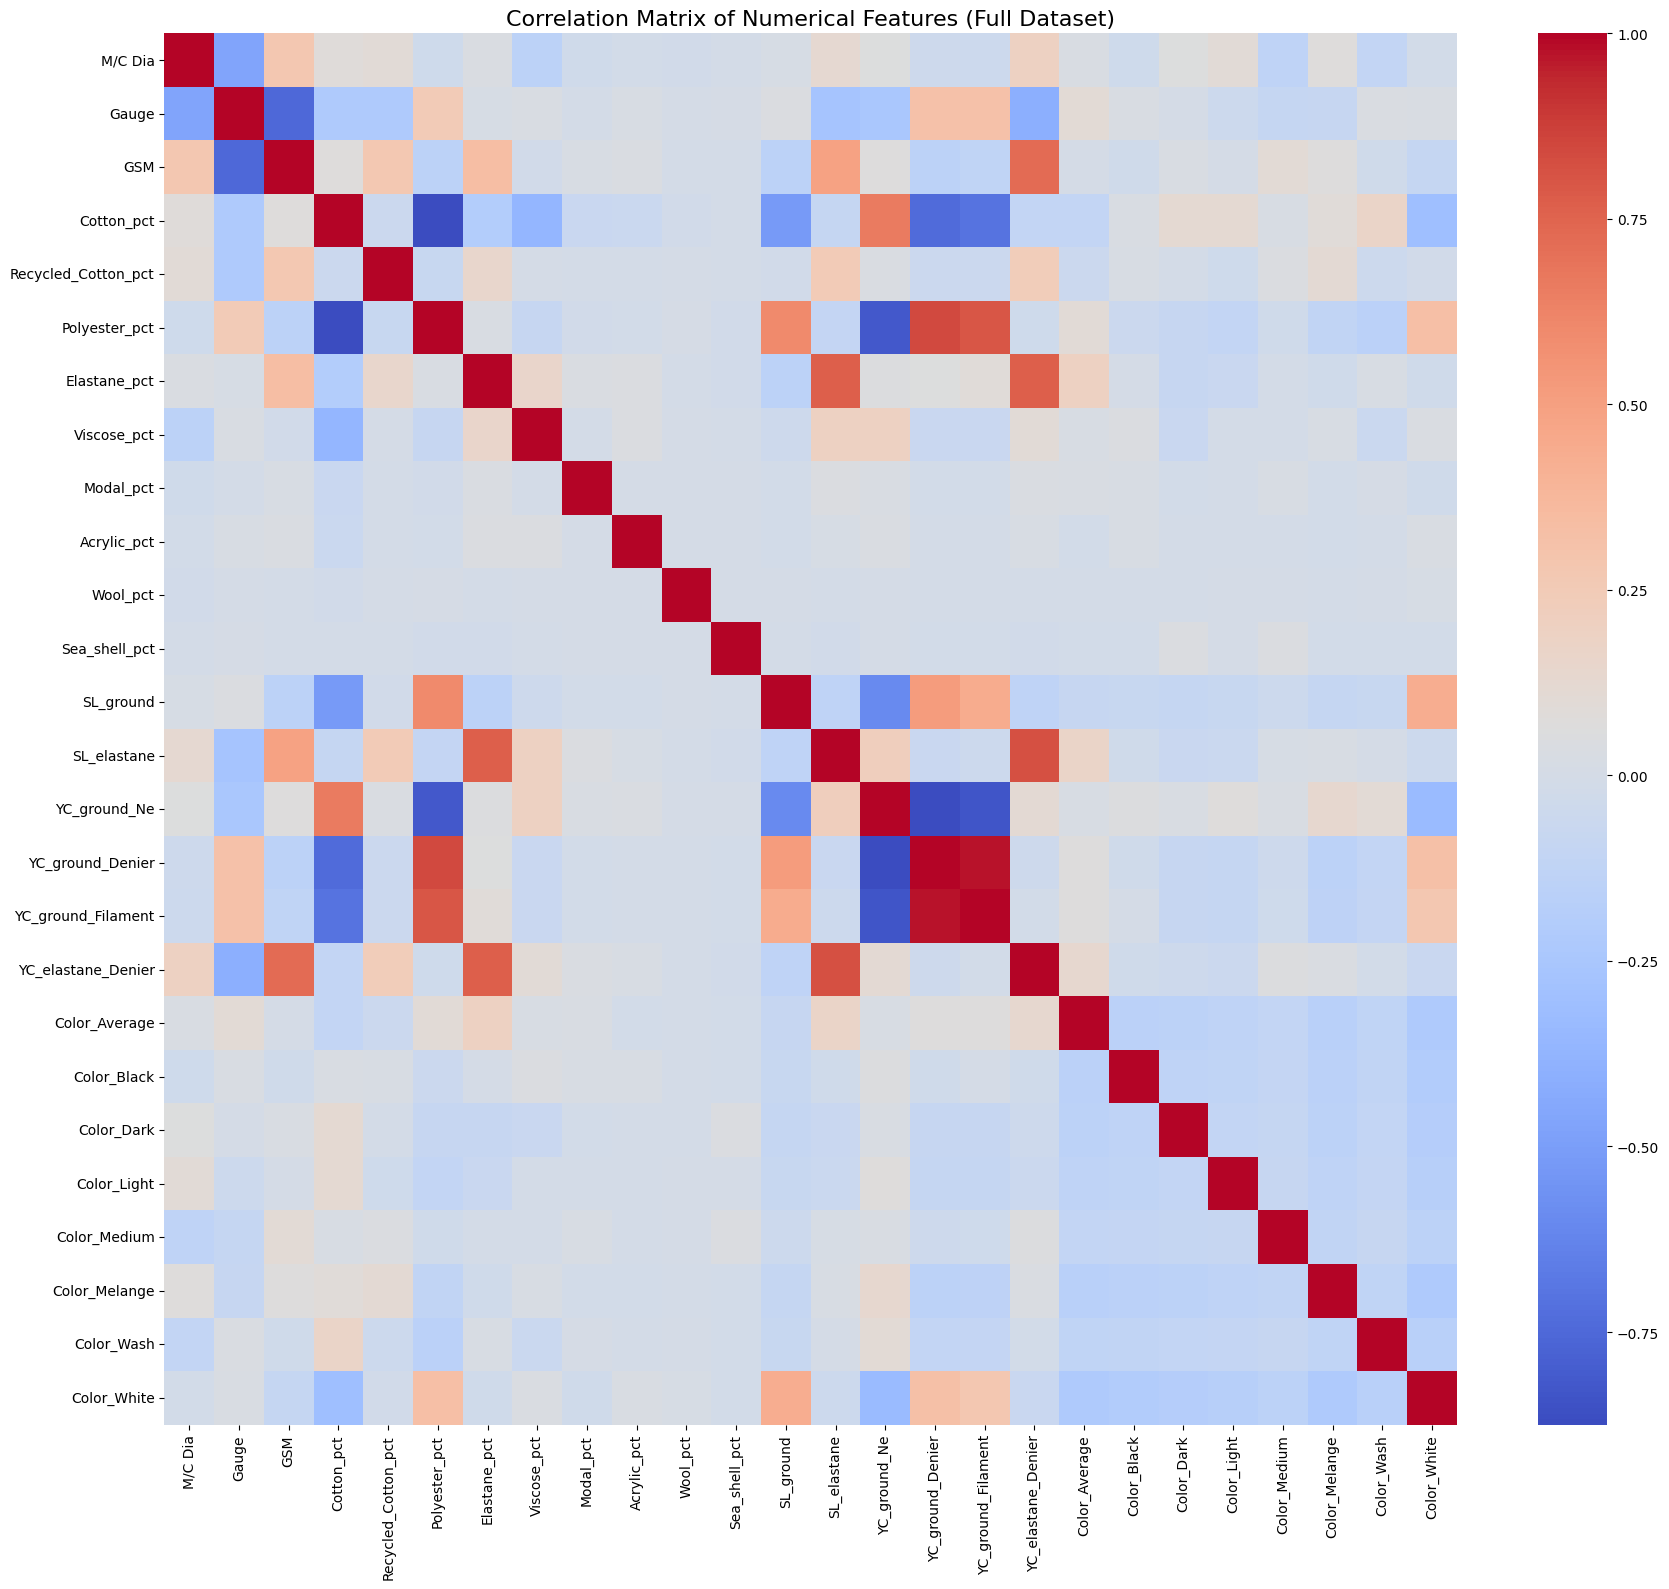

In [170]:
# Ensure GSM is numeric in df3 for plotting
df3['GSM'] = df3['GSM'].astype(str).str.replace(r'[^\d.]', '', regex=True).str.strip()
df3['GSM'] = pd.to_numeric(df3['GSM'], errors='coerce')

# --- Correlation Heatmap of Numerical Features ---
print("Generating Correlation Heatmap...")

# Identify all numerical columns including percentages, M/C Dia, Gauge, GSM, and target variables
numerical_cols_df3 = [
    'M/C Dia', 'Gauge', 'GSM',
    'Cotton_pct', 'Recycled_Cotton_pct', 'Polyester_pct', 'Elastane_pct',
    'Viscose_pct', 'Modal_pct', 'Acrylic_pct', 'Wool_pct', 'Sea_shell_pct',
    'SL_ground', 'SL_elastane', 'YC_ground_Ne', 'YC_ground_Denier', 'YC_ground_Filament', 'YC_elastane_Denier'
]

# Add one-hot encoded color columns to numerical features for correlation
color_ohe_cols = [col for col in df3.columns if col.startswith('Color_')]
numerical_cols_df3.extend(color_ohe_cols)

# Filter df3 to include only these numerical columns and drop rows with NaN for correlation
df3_numerical_for_corr = df3[numerical_cols_df3].dropna()

# Calculate the correlation matrix
correlation_matrix = df3_numerical_for_corr.corr()

# Plot the heatmap
plt.figure(figsize=(18, 16))
sns.heatmap(correlation_matrix, annot=False, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix of Numerical Features (Full Dataset)', fontsize=16)
plt.xticks(rotation=90)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()


Generating Frequency Plots for Categorical Features...


/tmp/ipython-input-2550488896.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(y=df3['Fabrication'], order=df3['Fabrication'].value_counts().index, palette='viridis')


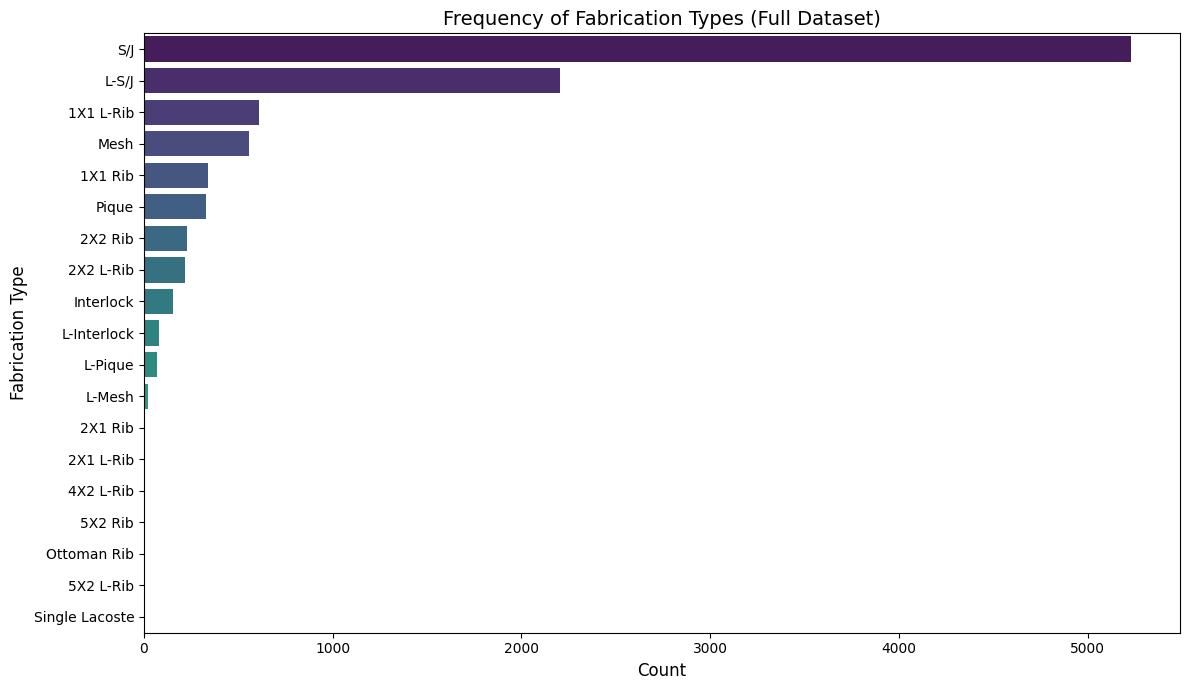

In [171]:
# --- Frequencies of Input Features ---
print("\nGenerating Frequency Plots for Categorical Features...")

# Fabrication (still object type in df3)
plt.figure(figsize=(12, 7))
sns.countplot(y=df3['Fabrication'], order=df3['Fabrication'].value_counts().index, palette='viridis')
plt.title('Frequency of Fabrication Types (Full Dataset)', fontsize=14)
plt.xlabel('Count', fontsize=12)
plt.ylabel('Fabrication Type', fontsize=12)
plt.tight_layout()
plt.show()

/tmp/ipython-input-3172848677.py:14: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x=df3_colors, order=df3_colors.value_counts().index, palette='plasma')


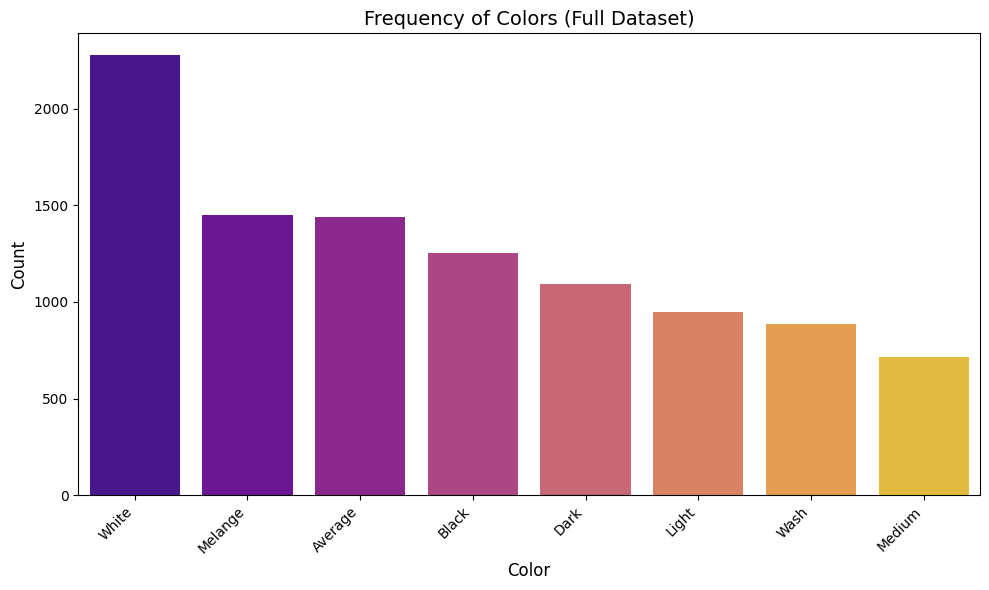

In [172]:
# Color features (reconstruct from one-hot encoded columns in df3)
# Ensure all possible Color_ columns are considered, even if some don't exist in a specific subset
all_possible_color_cols = [f'Color_{c}' for c in ['Average', 'Black', 'Dark', 'Light', 'Medium', 'Melange', 'Wash', 'White']]
existing_color_cols = [col for col in all_possible_color_cols if col in df3.columns]

if existing_color_cols:
    # Create a temporary DataFrame with only the existing one-hot encoded color columns
    temp_colors_df = df3[existing_color_cols].copy()
    # For each row, find the column that is True (or has the highest value if it's numeric)
    # .idxmax(axis=1) returns the column name, which we then clean up to get the color name
    df3_colors = temp_colors_df.idxmax(axis=1).str.replace('Color_', '')

    plt.figure(figsize=(10, 6))
    sns.countplot(x=df3_colors, order=df3_colors.value_counts().index, palette='plasma')
    plt.title('Frequency of Colors (Full Dataset)', fontsize=14)
    plt.xlabel('Color', fontsize=12)
    plt.ylabel('Count', fontsize=12)
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()
else:
    print("No 'Color_' one-hot encoded columns found in df3 for frequency plot.")


Generating Histograms for Numerical Features...


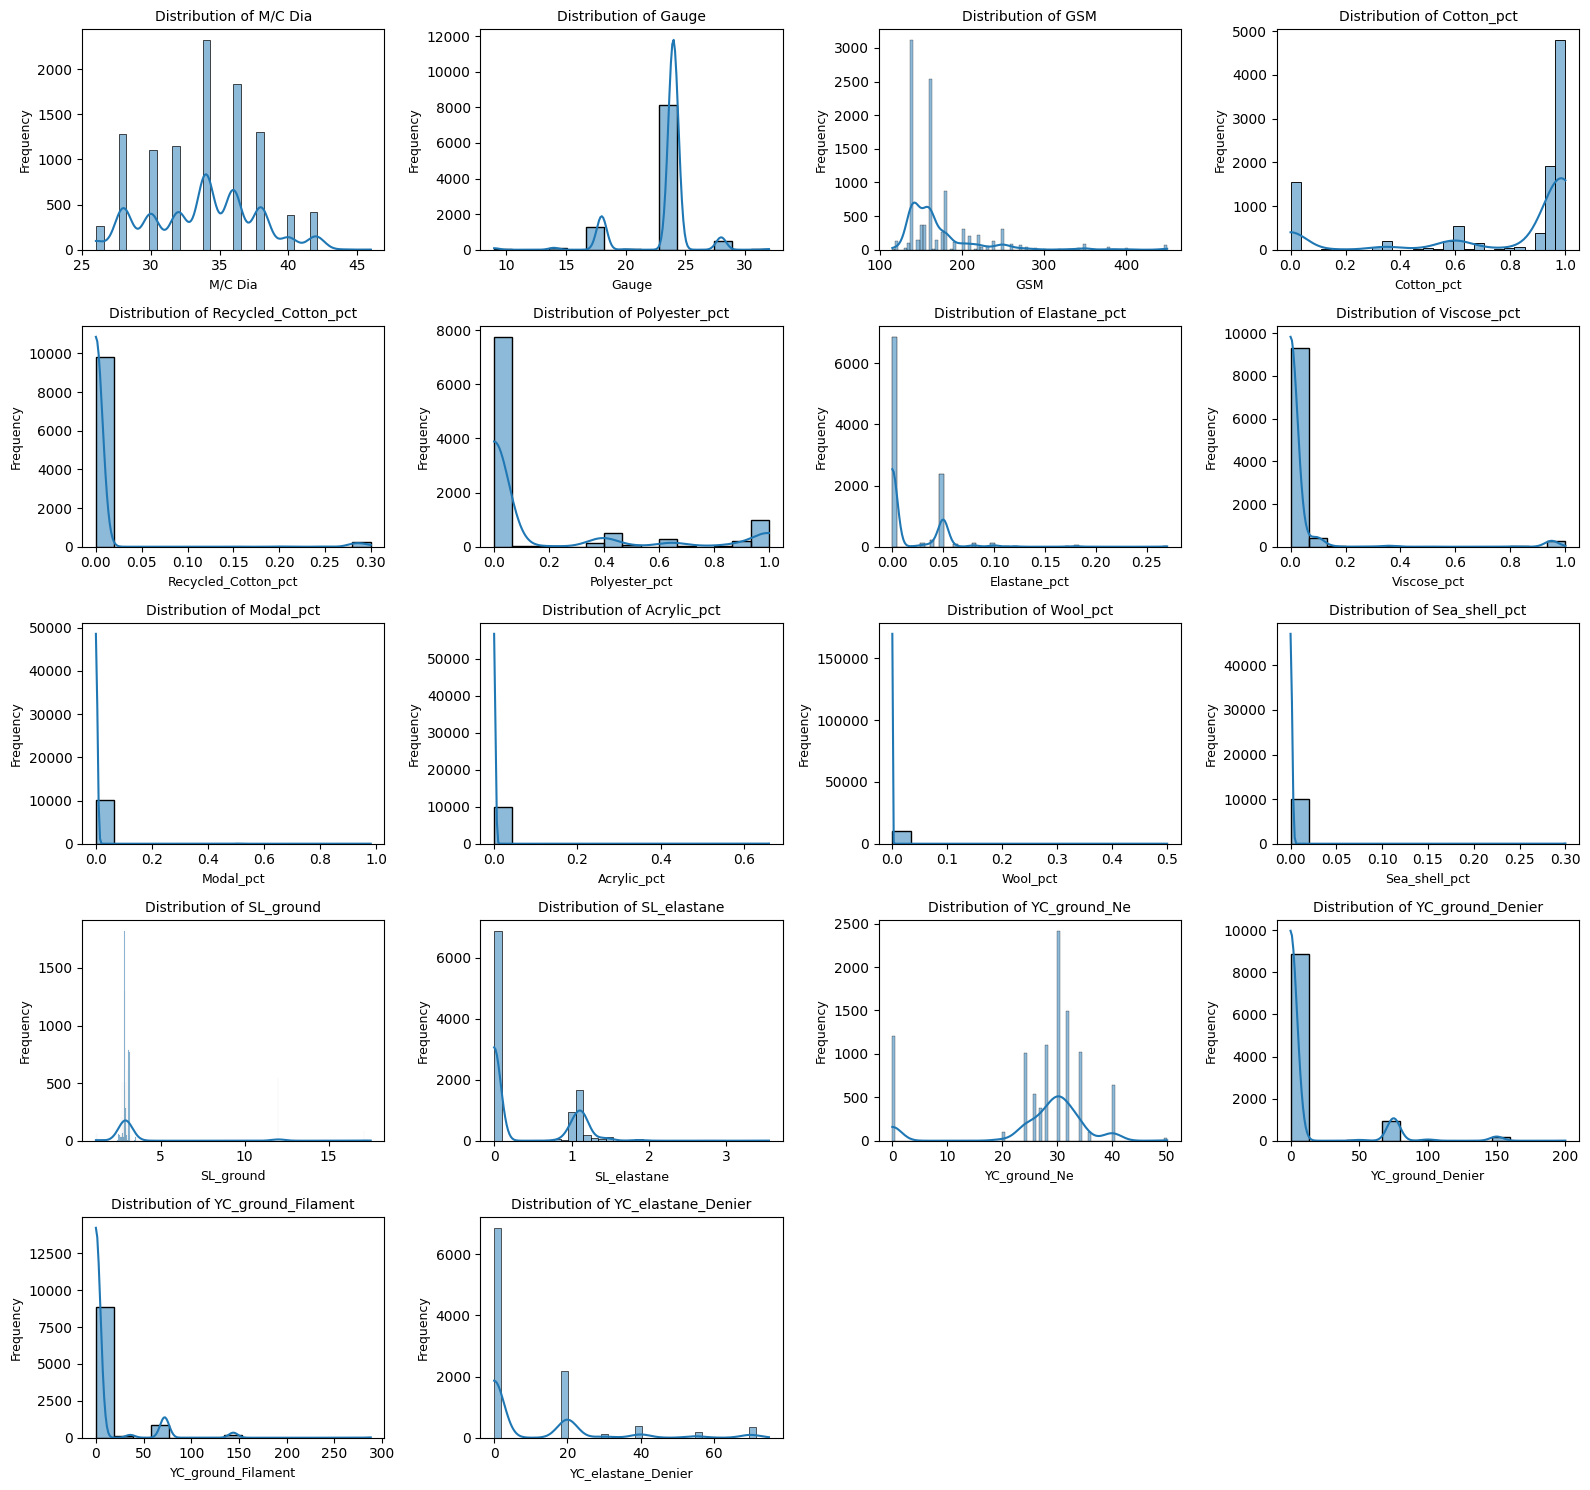

In [173]:
print("\nGenerating Histograms for Numerical Features...")
# Frequency plots (histograms) for numerical features
numerical_features_for_hist = ['M/C Dia', 'Gauge', 'GSM']
numerical_features_for_hist.extend([f for f in df3.columns if f.endswith('_pct')])
# Also include the split Stitch Length and Yarn Count features
numerical_features_for_hist.extend(['SL_ground', 'SL_elastane', 'YC_ground_Ne', 'YC_ground_Denier', 'YC_ground_Filament', 'YC_elastane_Denier'])

# Filter for actual existing columns in df3
numerical_features_for_hist = [col for col in numerical_features_for_hist if col in df3.columns]

# Determine grid size dynamically
num_plots = len(numerical_features_for_hist)
cols = 4
rows = (num_plots + cols - 1) // cols # Ceiling division

plt.figure(figsize=(cols * 4, rows * 3))
for i, col in enumerate(numerical_features_for_hist):
    plt.subplot(rows, cols, i + 1)
    sns.histplot(df3[col].dropna(), kde=True)
    plt.title(f'Distribution of {col}', fontsize=10)
    plt.xlabel(col, fontsize=9)
    plt.ylabel('Frequency', fontsize=9)
plt.tight_layout()
plt.show()

In [174]:
TARGET_COLS = [
    "SL_ground",
    "SL_elastane",
    "YC_ground_Ne",
    "YC_ground_Denier",
    "YC_ground_Filament",
    "YC_elastane_Denier"
]

X = df3.drop(columns=TARGET_COLS)
y = df3[TARGET_COLS]


In [175]:
X.shape

(10069, 21)

In [176]:
y.shape

(10069, 6)

In [177]:
# Drop rows where everything is zero (bad labels)
valid_mask = (y.sum(axis=1) > 0)
X = X[valid_mask]
y = y[valid_mask]

In [178]:
X.shape

(10069, 21)

In [179]:
# Fabrication → native categorical
X["Fabrication"] = X["Fabrication"].astype("category")

# Numeric columns
numeric_cols = ["M/C Dia", "Gauge", "GSM"]

# Clean GSM column before converting to numeric
X["GSM"] = X["GSM"].astype(str).str.replace(r'[^\d.]', '', regex=True).str.strip()

X[numeric_cols] = X[numeric_cols].apply(pd.to_numeric, errors="coerce")

In [180]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X,
    y,
    test_size=0.2,
    random_state=42,
    #stratify=X["Fabrication"]
)


In [181]:
import pandas as pd
import numpy as np

from sklearn.metrics import mean_absolute_error, r2_score
import matplotlib.pyplot as plt



In [182]:
import lightgbm as lgb

lgb_models = {}
lgb_preds = {}

cat_features_lgb = ["Fabrication"]

for target in TARGET_COLS:
    model = lgb.LGBMRegressor(
        n_estimators=500,  ## hyperprameter
        learning_rate=0.05,
        num_leaves=31,
        max_depth=-1,
        min_child_samples=20,
        subsample=0.8,
        colsample_bytree=0.8,
        random_state=42,
        force_row_wise=True
    )

      # model training
    model.fit(
        X_train,
        y_train[target],
        categorical_feature=cat_features_lgb
    )

    # model testing
    lgb_models[target] = model
    lgb_preds[target] = model.predict(X_test)



[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Total Bins 198
[LightGBM] [Info] Number of data points in the train set: 8055, number of used features: 18
[LightGBM] [Info] Start training from score 3.507182
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Total Bins 198
[LightGBM] [Info] Number of data points in the train set: 8055, number of used features: 18
[LightGBM] [Info] Start training from score 0.360032
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Total Bins 198
[LightGBM] [Info] Number of data points in the train set: 8055, number of used features: 18
[LightGBM] [Info] Start training from score 26.619367
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Total Bins 198
[LightGBM] [Info] Number of data points in the train set: 8055, number of used features: 18
[LightGBM] [Info] St

In [183]:
lgb_results = []

for target in TARGET_COLS:
    mae = mean_absolute_error(y_test[target], lgb_preds[target])
    r2 = r2_score(y_test[target], lgb_preds[target])
    lgb_results.append(["LightGBM", target, mae, r2])

lgb_results = pd.DataFrame(
    lgb_results,
    columns=["Model", "Target", "MAE", "R2"]
)


In [184]:
!pip install catboost
from catboost import CatBoostRegressor

cat_models = {}
cat_preds = {}

cat_features_idx = [X_train.columns.get_loc("Fabrication")]

for target in TARGET_COLS:
    model = CatBoostRegressor(
        iterations=500,
        learning_rate=0.05,
        depth=8,
        loss_function="MAE",
        random_seed=42,
        verbose=False
    )

    model.fit(
        X_train,
        y_train[target],
        cat_features=cat_features_idx
    )

    cat_models[target] = model
    cat_preds[target] = model.predict(X_test)

In [185]:
cat_results = []

for target in TARGET_COLS:
    mae = mean_absolute_error(y_test[target], cat_preds[target])
    r2 = r2_score(y_test[target], cat_preds[target])
    cat_results.append(["CatBoost", target, mae, r2])

cat_results = pd.DataFrame(
    cat_results,
    columns=["Model", "Target", "MAE", "R2"]
)


In [186]:
from sklearn.preprocessing import LabelEncoder

X_train_xgb = X_train.copy()
X_test_xgb = X_test.copy()

le = LabelEncoder()
X_train_xgb["Fabrication"] = le.fit_transform(X_train_xgb["Fabrication"])
X_test_xgb["Fabrication"] = le.transform(X_test_xgb["Fabrication"])


In [187]:
from xgboost import XGBRegressor

xgb_models = {}
xgb_preds = {}

for target in TARGET_COLS:
    model = XGBRegressor(
        n_estimators=600,
        learning_rate=0.05,
        max_depth=6,
        subsample=0.8,
        colsample_bytree=0.8,
        objective="reg:squarederror",
        random_state=42,
        n_jobs=-1
    )

    model.fit(X_train_xgb, y_train[target])

    xgb_models[target] = model
    xgb_preds[target] = model.predict(X_test_xgb)


In [188]:
xgb_results = []

for target in TARGET_COLS:
    mae = mean_absolute_error(y_test[target], xgb_preds[target])
    r2 = r2_score(y_test[target], xgb_preds[target])
    xgb_results.append(["XGBoost", target, mae, r2])

xgb_results = pd.DataFrame(
    xgb_results,
    columns=["Model", "Target", "MAE", "R2"]
)


In [189]:
from sklearn.ensemble import RandomForestRegressor

rf_models = {}
rf_preds = {}

for target in TARGET_COLS:
    model = RandomForestRegressor(
        n_estimators=500,
        random_state=42,
        n_jobs=-1
    )

    # Train the model
    model.fit(X_train_xgb, y_train[target])

    # Store the trained model and predictions
    rf_models[target] = model
    rf_preds[target] = model.predict(X_test_xgb)

print("RandomForestRegressor models trained and predictions generated.")

RandomForestRegressor models trained and predictions generated.


In [190]:
rf_results = []

for target in TARGET_COLS:
    mae = mean_absolute_error(y_test[target], rf_preds[target])
    r2 = r2_score(y_test[target], rf_preds[target])
    rf_results.append(["RandomForest", target, mae, r2])

rf_results = pd.DataFrame(
    rf_results,
    columns=["Model", "Target", "MAE", "R2"]
)


In [191]:
results_df = pd.concat(
    [lgb_results, cat_results, xgb_results, rf_results],
    ignore_index=True
)

results_df

,Model,Target,MAE,R2
0,LightGBM,SL_ground,0.030557,0.999080
1,LightGBM,SL_elastane,0.012179,0.986417
2,LightGBM,YC_ground_Ne,0.496755,0.990754
3,LightGBM,YC_ground_Denier,0.278063,0.997173
4,LightGBM,YC_ground_Filament,0.350960,0.995155
5,LightGBM,YC_elastane_Denier,0.487544,0.981669
6,CatBoost,SL_ground,0.046337,0.996560
7,CatBoost,SL_elastane,0.009287,0.986330
8,CatBoost,YC_ground_Ne,0.600088,0.981769
9,CatBoost,YC_ground_Denier,0.093373,0.997785


In [192]:
mae_pivot = results_df.pivot(
    index="Target",
    columns="Model",
    values="MAE"
)

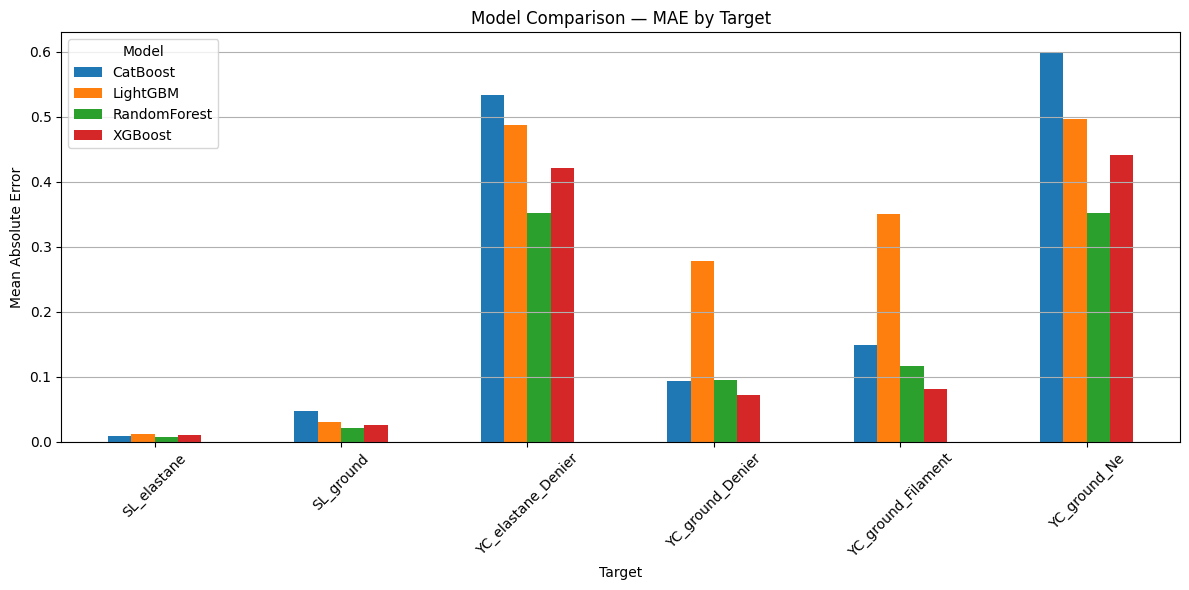

In [193]:
mae_pivot.plot(
    kind="bar",
    figsize=(12, 6)
)

plt.title("Model Comparison — MAE by Target")
plt.ylabel("Mean Absolute Error")
plt.xticks(rotation=45)
plt.grid(axis="y")
plt.tight_layout()
plt.show()


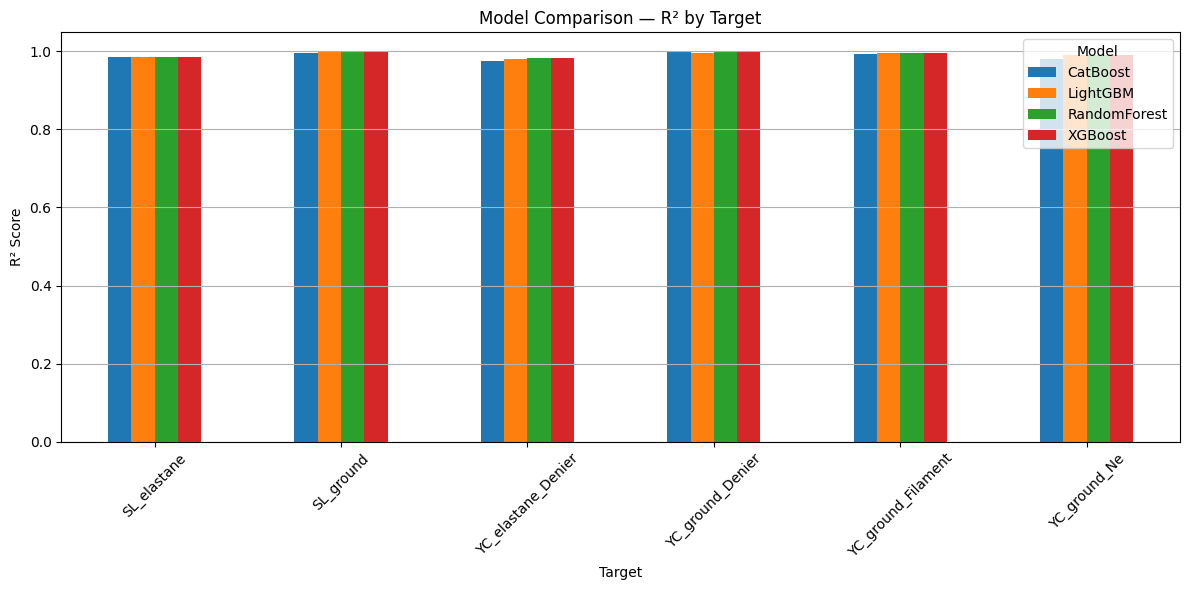

In [194]:
r2_pivot = results_df.pivot(
    index="Target",
    columns="Model",
    values="R2"
)

r2_pivot.plot(
    kind="bar",
    figsize=(12, 6)
)

plt.title("Model Comparison — R² by Target")
plt.ylabel("R² Score")
plt.xticks(rotation=45)
plt.grid(axis="y")
plt.tight_layout()
plt.show()


In [195]:
aggregated_results = results_df.groupby('Model')[['MAE', 'R2']].mean()

print("Overall Model Performance (Average across all targets):\n")
print(aggregated_results)

print("\n--- Best Model Selection ---")

# Best by average MAE (lower is better)
best_mae_model = aggregated_results['MAE'].idxmin()
min_mae = aggregated_results['MAE'].min()
print(f"Best model by average MAE: {best_mae_model} (Average MAE: {min_mae:.4f})")

# Best by average R2 (higher is better)
best_r2_model = aggregated_results['R2'].idxmax()
max_r2 = aggregated_results['R2'].max()
print(f"Best model by average R2: {best_r2_model} (Average R2: {max_r2:.4f})")

# You can also consider the sum of ranks for both metrics for a more holistic view
# For simplicity, we'll focus on MAE and R2 directly for now.

Overall Model Performance (Average across all targets):

                   MAE        R2
Model                           
CatBoost      0.238617  0.988511
LightGBM      0.276010  0.991708
RandomForest  0.157018  0.992325
XGBoost       0.175392  0.992366

--- Best Model Selection ---
Best model by average MAE: RandomForest (Average MAE: 0.1570)
Best model by average R2: XGBoost (Average R2: 0.9924)


In [196]:
VALID_COTTON_NE = sorted(
    df3["YC_ground_Ne"]
    .loc[df3["YC_ground_Ne"] > 0]
    .unique()
)

VALID_DENIER = sorted(
    pd.concat([
        df3["YC_ground_Denier"],
        df3["YC_elastane_Denier"]
    ])
    .loc[lambda x: x > 0]
    .unique()
)


In [197]:
def snap_to_valid(value, valid_list):
    if value <= 0 or len(valid_list) == 0:
        return None
    return min(valid_list, key=lambda x: abs(x - value))


In [201]:
print(le.classes_)  # See what the encoder expects

['1X1 L-Rib' '1X1 Rib' '2X1 L-Rib' '2X1 Rib' '2X2 L-Rib' '2X2 Rib'
 '4X2 L-Rib' '5X2 L-Rib' '5X2 Rib' 'Interlock' 'L-Interlock' 'L-Mesh'
 'L-Pique' 'L-S/J' 'Mesh' 'Ottoman Rib' 'Pique' 'S/J' 'Single Lacoste']


In [198]:
import pandas as pd
import numpy as np

# ================================
# 1. TARGET DEFINITIONS
# ================================
TARGET_COLS = [
    "SL_ground",
    "SL_elastane",
    "YC_ground_Ne",
    "YC_ground_Denier",
    "YC_ground_Filament",
    "YC_elastane_Denier"
]

# ================================
# 2. PHYSICAL CONSTRAINTS
# ================================
def apply_constraints(X, y_pred):
    y_pred = y_pred.copy()

    # No elastane → no elastane SL or yarn
    no_elastane = X["Elastane_pct"] == 0
    y_pred.loc[no_elastane, "SL_elastane"] = 0.0
    y_pred.loc[no_elastane, "YC_elastane_Denier"] = 0.0

    return y_pred

# ================================
# 3. STITCH LENGTH FORMATTER
# ================================
def format_stitch_length(row, thr=0.05):
    g = round(float(row["SL_ground"]), 2)
    e = round(float(row["SL_elastane"]), 2)

    if e >= thr:
        return f"{g:.2f}/{e:.2f}"
    else:
        return f"{g:.2f}"

# ================================
# 4. VALID YARN COUNT SETS
# ================================
VALID_COTTON_NE = sorted(
    df3["YC_ground_Ne"].loc[df3["YC_ground_Ne"] > 0].unique()
)

VALID_DENIER = sorted(
    pd.concat([
        df3["YC_ground_Denier"],
        df3["YC_elastane_Denier"]
    ]).loc[lambda x: x > 0].unique()
)

def snap_to_valid(value, valid_list):
    if value <= 0 or len(valid_list) == 0:
        return None
    return min(valid_list, key=lambda x: abs(x - value))

# ================================
# 5. YARN COUNT FORMATTER
# ================================
def format_yarn_count(row):
    parts = []

    ne = row["YC_ground_Ne"]
    den = row["YC_ground_Denier"]
    fil = row["YC_ground_Filament"]
    ela = row["YC_elastane_Denier"]

    # Ground yarn (cotton OR synthetic)
    snapped_ne = snap_to_valid(ne, VALID_COTTON_NE)
    snapped_den = snap_to_valid(den, VALID_DENIER)
    snapped_ela = snap_to_valid(ela, VALID_DENIER)

    if snapped_ne is not None:
        parts.append(f"{int(snapped_ne)}/1")

    elif snapped_den is not None and fil > 5:
        parts.append(f"{int(snapped_den)}D/{int(round(fil))}F")

    # Elastane yarn
    if snapped_ela is not None:
        parts.append(f"{int(snapped_ela)}D")

    return ",".join(parts)

# ================================
# 6. BUILD NUMERIC PREDICTIONS
# ================================
# Example uses XGBoost models
# (same logic works for LightGBM / CatBoost)

y_pred_numeric = pd.DataFrame(
    {t: xgb_models[t].predict(X_test_xgb) for t in TARGET_COLS},
    index=X_test.index
)

y_pred_numeric = apply_constraints(X_test, y_pred_numeric)

# ================================
# 7. FORMAT PREDICTIONS
# ================================
y_pred_formatted = pd.DataFrame({
    "Predicted_Stitch_Length": y_pred_numeric.apply(format_stitch_length, axis=1),
    "Predicted_Yarn_Count": y_pred_numeric.apply(format_yarn_count, axis=1)
}, index=y_pred_numeric.index)

# ================================
# 8. FORMAT ACTUAL VALUES
# ================================
y_actual_formatted = pd.DataFrame({
    "Actual_Stitch_Length": y_test.apply(format_stitch_length, axis=1),
    "Actual_Yarn_Count": y_test.apply(format_yarn_count, axis=1)
}, index=y_test.index)

# ================================
# 9. RECONSTRUCT USER INPUT FEATURES
# ================================
# Remove 'Color' from the list as it was one-hot encoded
input_features = X_test[[
    "Fabrication",
    "M/C Dia",
    "Gauge",
    "GSM"
]].copy()

# Reconstruct 'Color' from one-hot encoded columns for display
color_cols = [col for col in X_test.columns if col.startswith('Color_')]
if color_cols:
    input_features['Color'] = X_test[color_cols].idxmax(axis=1).str.replace('Color_', '')
else:
    input_features['Color'] = pd.NA # Handle case where no color columns exist


fiber_cols = [c for c in X_test.columns if c.endswith("_pct")]

def reconstruct_composition(row):
    parts = []
    for col in fiber_cols:
        pct = row[col]
        if pct > 0.01:
            # Use a dictionary to map '_pct' column names to user-friendly fiber names if needed
            # For example, if 'Recycled_Cotton_pct' should show as 'Recycled Cotton'
            fiber_name = col.replace('_pct', '').replace('_', ' ').strip()
            parts.append(f"{int(round(pct*100))}% {fiber_name}")
    return ", ".join(parts)

input_features["Composition"] = X_test.apply(reconstruct_composition, axis=1)

# Reorder columns to place 'Color' and 'Composition' appropriately
final_input_features_order = [
    "Fabrication",
    "Composition",
    "M/C Dia",
    "Gauge",
    "Color",
    "GSM"
]

input_features = input_features[final_input_features_order]

# ================================
# 10. FINAL COMPARISON DATAFRAME
# ================================
final_comparison_df = pd.concat(
    [
        input_features,
        y_actual_formatted,
        y_pred_formatted
    ],
    axis=1
)

# ================================
# 11. DISPLAY & EXPORT
# ================================
print("\nFINAL ACTUAL vs PREDICTED OUTPUT\n")
display(final_comparison_df.head(20))

# Optional: Export to Excel
final_comparison_df.to_excel("actual_vs_predicted_results.xlsx", index=True)


FINAL ACTUAL vs PREDICTED OUTPUT



,Fabrication,Composition,M/C Dia,Gauge,Color,GSM,Actual_Stitch_Length,Actual_Yarn_Count,Predicted_Stitch_Length,Predicted_Yarn_Count
1141,S/J,"60% Cotton, 40% Polyester",38,24,Average,140,2.90,30/1,2.90,30/1
338,L-S/J,"95% Cotton, 5% Elastane",38,24,Average,160,3.15/1.15,"34/1,20D",3.15/1.15,"34/1,20D"
7354,Pique,100% Cotton,30,24,Wash,180,3.00,28/1,2.92,27/1
1169,S/J,"60% Cotton, 40% Polyester",38,24,Average,140,2.90,30/1,2.90,30/1
33,1X1 L-Rib,"96% Polyester, 4% Elastane",38,18,Average,260,2.90/1.18,"150D/144F,70D",2.81/1.17,"14/1,70D"
990,S/J,"60% Cotton, 40% Polyester",32,24,Average,175,3.15,24/1,3.14,24/1
9608,S/J,100% Cotton,34,24,White,160,2.86,27/1,2.86,27/1
4875,1X1 L-Rib,"67% Cotton, 30% Recycled Cotton, 3% Elastane",42,14,Medium,450,3.60/1.30,"28/1,70D",3.60/1.31,"28/1,70D"
6687,S/J,"90% Cotton, 10% Viscose",32,24,Melange,140,2.95,30/1,2.94,30/1
3479,S/J,100% Cotton,34,24,Dark,140,2.90,30/1,2.87,32/1


In [209]:
import pandas as pd
import numpy as np

# Get user input for prediction
user_fabrication = input("Enter Fabrication (e.g., S/J): ")
user_composition = input("Enter Composition (e.g., 70% Cotton, 30% Polyester): ")
user_mc_dia = int(input("Enter M/C Dia (e.g., 30): "))
user_gauge = int(input("Enter Gauge (e.g., 24): "))
user_color = input("Enter Color (e.g., White): ")
user_gsm = int(input("Enter GSM (e.g., 150): "))

# Create a dictionary from user inputs
sample_input = {
    'Fabrication': user_fabrication,
    'Composition': user_composition,
    'M/C Dia': user_mc_dia,
    'Gauge': user_gauge,
    'Color': user_color,
    'GSM': user_gsm,
}

# Convert sample input to DataFrame
input_df = pd.DataFrame([sample_input])

# --- Preprocessing steps (mirroring training data preprocessing) ---

# 1. Fabrication standardization
input_df['Fabrication'] = input_df['Fabrication'].astype(str).str.strip().str.upper()
input_df['Fabrication'] = input_df['Fabrication'].str.replace(r'[×\*]', 'X', regex=True)
input_df['Fabrication'] = input_df['Fabrication'].str.replace(r'\s', '', regex=True)
input_df['Fabrication'] = input_df['Fabrication'].replace(mapping_dict)
input_df['Fabrication'] = le.transform(input_df['Fabrication'])

# 2. Color standardization and one-hot encoding
input_df['Color'] = input_df['Color'].astype(str).str.replace(r'avg|Average', 'Average', case=False, regex=True)
input_df['Color'] = input_df['Color'].astype(str).str.replace(r'white', 'White', case=False, regex=True).str.strip()
input_df['Color'] = input_df['Color'].astype(str).str.replace(r'black', 'Black', case=False, regex=True).str.strip()

# Create one-hot encoded columns for all possible colors found during training
all_colors = ['Average', 'Black', 'Dark', 'Light', 'Medium', 'Melange', 'Wash', 'White'] # These should come from X.columns for consistency
for color in all_colors:
    input_df[f'Color_{color}'] = (input_df['Color'] == color)

input_df.drop(columns=['Color'], inplace=True)

# 3. Composition parsing
composition_single_df = input_df["Composition"].apply(split_composition)
input_df = pd.concat([input_df, composition_single_df], axis=1)
input_df.drop(columns=["Composition"], inplace=True)

# Ensure numeric columns are correct type and clean GSM
input_df["GSM"] = input_df["GSM"].astype(str).str.replace(r'[^‌​\d.]', '', regex=True).str.strip()
input_df['GSM'] = pd.to_numeric(input_df['GSM'], errors='coerce')
input_df['M/C Dia'] = pd.to_numeric(input_df['M/C Dia'], errors='coerce')
input_df['Gauge'] = pd.to_numeric(input_df['Gauge'], errors='coerce')

# Align columns to X_train_xgb (which already has Fabrication label encoded)
aligned_input_df = pd.DataFrame(columns=X_train_xgb.columns)
for col in X_train_xgb.columns:
    if col in input_df.columns:
        aligned_input_df[col] = input_df[col]
    else:
        # For missing one-hot encoded color columns, fill with False
        if col.startswith('Color_'):
            aligned_input_df[col] = False
        else:
            # For any other missing columns (e.g., specific fiber_pct not in input)
            aligned_input_df[col] = 0.0

aligned_input_df = aligned_input_df.infer_objects(copy=False)

# --- Make predictions ---
y_pred_numeric_single = pd.DataFrame(
    {t: rf_models[t].predict(aligned_input_df) for t in TARGET_COLS},
    index=aligned_input_df.index
)

# Apply physical constraints
y_pred_numeric_single = apply_constraints(input_df, y_pred_numeric_single)

# --- Format predictions ---
y_pred_formatted_single = pd.DataFrame({
    "Predicted_Stitch_Length": y_pred_numeric_single.apply(format_stitch_length, axis=1),
    "Predicted_Yarn_Count": y_pred_numeric_single.apply(format_yarn_count, axis=1)
}, index=y_pred_numeric_single.index)

print("\nSingle Prediction Output:")
display(y_pred_formatted_single)


Enter Fabrication (e.g., S/J): L-s/j
Enter Composition (e.g., 70% Cotton, 30% Polyester): 100% cotton
Enter M/C Dia (e.g., 30): 28
Enter Gauge (e.g., 24): 23
Enter Color (e.g., White): white
Enter GSM (e.g., 150): 150

Single Prediction Output:


,Predicted_Stitch_Length,Predicted_Yarn_Count
0,2.53,34/1


In [200]:
import pickle
pickle.dump(X_train_xgb.columns.tolist(), open("X_columns.pkl", "wb"))


In [202]:
# Save valid values for Streamlit
pickle.dump(VALID_COTTON_NE, open("valid_cotton_ne.pkl", "wb"))
pickle.dump(VALID_DENIER, open("valid_denier.pkl", "wb"))

print("Saved VALID_COTTON_NE and VALID_DENIER!")

Saved VALID_COTTON_NE and VALID_DENIER!


In [ ]:
import joblib
import os

# Create a directory to save the label encoder if it doesn't exist
encoders_dir = 'trained_encoders'
os.makedirs(encoders_dir, exist_ok=True)

# Save the LabelEncoder object
joblib.dump(le, os.path.join(encoders_dir, 'fabrication_label_encoder.pkl'))

print(f"Label encoder for 'Fabrication' saved to {os.path.join(encoders_dir, 'fabrication_label_encoder.pkl')}")

Label encoder for 'Fabrication' saved to trained_encoders/fabrication_label_encoder.pkl


In [ ]:
import joblib
import os

# Directory to save models
models_dir = 'trained_models'
os.makedirs(models_dir, exist_ok=True)

# Save each RandomForest model to a pickle file
for target, model in rf_models.items():
    filename = os.path.join(models_dir, f'random_forest_model_{target}.pkl')
    joblib.dump(model, filename)
    print(f'Saved {target} model to {filename}')

print('\nAll RandomForest models saved successfully.')

Saved SL_ground model to trained_models/random_forest_model_SL_ground.pkl
Saved SL_elastane model to trained_models/random_forest_model_SL_elastane.pkl
Saved YC_ground_Ne model to trained_models/random_forest_model_YC_ground_Ne.pkl
Saved YC_ground_Denier model to trained_models/random_forest_model_YC_ground_Denier.pkl
Saved YC_ground_Filament model to trained_models/random_forest_model_YC_ground_Filament.pkl
Saved YC_elastane_Denier model to trained_models/random_forest_model_YC_elastane_Denier.pkl

All RandomForest models saved successfully.
